In [1]:
import re
import gensim
import string
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
from numpy import zeros
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from numpy import asarray
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.layers import Flatten
from keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.layers import Embedding
from keras.models import Sequential
from collections import defaultdict
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from keras.initializers import Constant

#### Read and analyze data, via the head().

In [ ]:
data= pd.read_csv('https://raw.githubusercontent.com/musakanneh/spam_classifier/main/spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


#### From the analyzed data, get the first five emails - using the head function.

In [ ]:
data["email"].head()

0     date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...
1    martin a posted tassos papadopoulos the greek ...
2    man threatens explosion in moscow thursday aug...
3    klez the virus that won t die already the most...
4     in adding cream to spaghetti carbonara which ...
Name: email, dtype: object

#### Apply a lambda function to splict the emails and get the email labels

In [ ]:
data['email'] = data['email'].apply(lambda x: str(x).split(" "))
data.head()

,email,label
0,"[, date, wed, NUMBER, aug, NUMBER, NUMBER, NUM...",0
1,"[martin, a, posted, tassos, papadopoulos, the,...",0
2,"[man, threatens, explosion, in, moscow, thursd...",0
3,"[klez, the, virus, that, won, t, die, already,...",0
4,"[, in, adding, cream, to, spaghetti, carbonara...",0


### Understanding the state of the data

In [ ]:
data.describe()

,label
count,3000.000000
mean,0.166667
std,0.372740
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


#### Using a pie chart to understand data labels regarding the spam <br/>and ham messages; then apply the length of emails to our datagframe

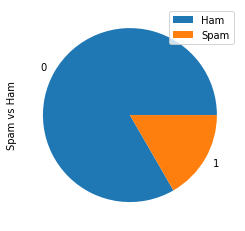

In [ ]:
data["label"].value_counts().plot(kind = 'pie')
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [ ]:
data['length']=data['email'].apply(len)
data.head()

,email,label,length
0,"[, date, wed, NUMBER, aug, NUMBER, NUMBER, NUM...",0,259
1,"[martin, a, posted, tassos, papadopoulos, the,...",0,114
2,"[man, threatens, explosion, in, moscow, thursd...",0,257
3,"[klez, the, virus, that, won, t, die, already,...",0,170
4,"[, in, adding, cream, to, spaghetti, carbonara...",0,146


#### Aalysing the lenght of messages based on ham and spam messages by:
> distributing data into labels with color indications and attributes<br />

Text(0.5, 0, 'Message Length')

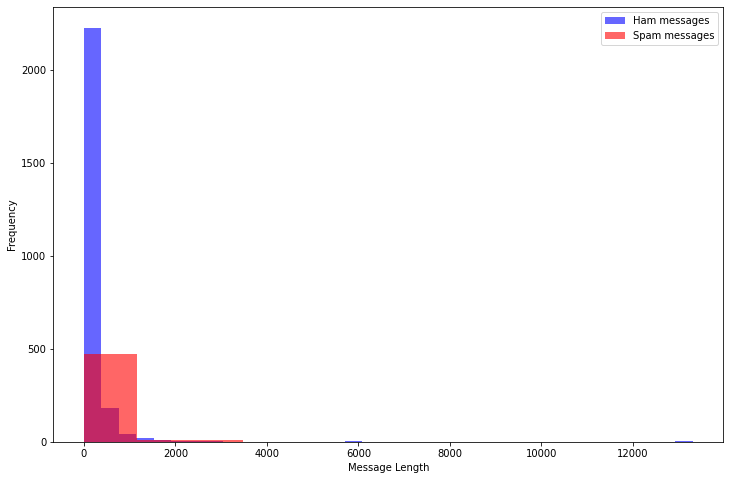

In [ ]:
plt.figure(figsize=(12, 8))
data[data.label==0].length.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
data[data.label==1].length.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

#### Tokenize text to sequences, validate and print words; then 
> use integer values to encode the documents

In [ ]:
docs = data['email']
t = Tokenizer()
t.fit_on_texts(docs)
encoded_docs = t.texts_to_sequences(docs)
vocab_size = len(t.word_index) + 1
word_index=t.word_index

In [ ]:
import pickle
filename = 'tokenize.sav'
outfile = open(filename,'wb')
pickle.dump(t,outfile)
outfile.close()

In [ ]:
print(t.word_index.items())

dict_items([('number', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('a', 6), ('in', 7), ('i', 8), ('url', 9), ('is', 10), ('that', 11), ('you', 12), ('it', 13), ('for', 14), ('this', 15), ('on', 16), ('s', 17), ('with', 18), ('', 19), ('be', 20), ('have', 21), ('are', 22), ('from', 23), ('not', 24), ('as', 25), ('t', 26), ('or', 27), ('your', 28), ('at', 29), ('by', 30), ('if', 31), ('but', 32), ('we', 33), ('can', 34), ('was', 35), ('an', 36), ('all', 37), ('will', 38), ('list', 39), ('my', 40), ('they', 41), ('so', 42), ('has', 43), ('one', 44), ('do', 45), ('more', 46), ('there', 47), ('get', 48), ('our', 49), ('no', 50), ('just', 51), ('out', 52), ('about', 53), ('what', 54), ('which', 55), ('people', 56), ('time', 57), ('their', 58), ('up', 59), ('use', 60), ('would', 61), ('only', 62), ('like', 63), ('new', 64), ('he', 65), ('who', 66), ('any', 67), ('free', 68), ('email', 69), ('now', 70), ('some', 71), ('me', 72), ('when', 73), ('don', 74), ('other', 75), ('mail', 76), ('

In [ ]:
print(encoded_docs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding= 'post')
print(padded_docs)

[[  590     9     9    19]
 [  152     3     9    19]
 [  152     3     9    19]
 ...
 [    2   152   145    19]
 [   23    12   775    19]
 [18882 18883    79    19]]


> Save tokenized content to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embedding_dict={}
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

> use embeded vectors to get words from the dictionary; then
> prepare model for training

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
for word,i in word_index.items():
    if i > num_words:
        continue
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

In [ ]:
X_train,X_val, y_train, y_val = train_test_split(padded_docs,data.label, test_size=.2, random_state=2)

In [ ]:
print('Shape of train sequences: ',X_train.shape)
print('Shape of train labels: ',y_train.shape)
print("Shape of Validation sequences: ",X_val.shape)
print("Shape of Validation  labels: ",y_val.shape)

Shape of train sequences:  (2400, 4)
Shape of train labels:  (2400,)
Shape of Validation sequences:  (600, 4)
Shape of Validation  labels:  (600,)


In [ ]:
model=Sequential()

embedding_layer=Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)

model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            3422100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 4, 100)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 64)             42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
history=model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val),verbose=1)

Epoch 1/10
75/75 [==============================] - 5s 67ms/step - loss: 0.6811 - acc: 0.8304 - val_loss: 0.6651 - val_acc: 0.8350
Epoch 2/10
75/75 [==============================] - 4s 51ms/step - loss: 0.6290 - acc: 0.8329 - val_loss: 0.5693 - val_acc: 0.8350
Epoch 3/10
75/75 [==============================] - 4s 48ms/step - loss: 0.4575 - acc: 0.8329 - val_loss: 0.3912 - val_acc: 0.8350
Epoch 4/10
75/75 [==============================] - 4s 55ms/step - loss: 0.3480 - acc: 0.8329 - val_loss: 0.3606 - val_acc: 0.8350
Epoch 5/10
75/75 [==============================] - 4s 57ms/step - loss: 0.3076 - acc: 0.8329 - val_loss: 0.3442 - val_acc: 0.8350
Epoch 6/10
75/75 [==============================] - 4s 48ms/step - loss: 0.2757 - acc: 0.8433 - val_loss: 0.3348 - val_acc: 0.8583
Epoch 7/10
75/75 [==============================] - 4s 47ms/step - loss: 0.2525 - acc: 0.8825 - val_loss: 0.3271 - val_acc: 0.8850
Epoch 8/10
75/75 [==============================] - 4s 48ms/step - loss: 0.2335 - a

In [ ]:
test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2)
print('Model accuracy: ',test_acc*100)

19/19 - 0s - loss: 0.3087 - acc: 0.8950
Model accuracy:  89.49999809265137


In [ ]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPool1D(1))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.summary()
model3.add(Dense(1, activation='sigmoid'))


model3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            3422100   
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2, 32)            

In [ ]:
history=model3.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val),verbose=1)

Epoch 1/10
75/75 [==============================] - 3s 39ms/step - loss: 0.4282 - accuracy: 0.8315 - val_loss: 0.3356 - val_accuracy: 0.8350
Epoch 2/10
75/75 [==============================] - 4s 56ms/step - loss: 0.2052 - accuracy: 0.9052 - val_loss: 0.2721 - val_accuracy: 0.8733
Epoch 3/10
75/75 [==============================] - 3s 37ms/step - loss: 0.0996 - accuracy: 0.9644 - val_loss: 0.2772 - val_accuracy: 0.8883
Epoch 4/10
75/75 [==============================] - 3s 42ms/step - loss: 0.0732 - accuracy: 0.9706 - val_loss: 0.2840 - val_accuracy: 0.8925
Epoch 5/10
75/75 [==============================] - 3s 40ms/step - loss: 0.0660 - accuracy: 0.9710 - val_loss: 0.3292 - val_accuracy: 0.8825
Epoch 6/10
75/75 [==============================] - 3s 44ms/step - loss: 0.0630 - accuracy: 0.9748 - val_loss: 0.3111 - val_accuracy: 0.8958
Epoch 7/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0608 - accuracy: 0.9752 - val_loss: 0.3179 - val_accuracy: 0.9017
Epoch 8/10
75

In [ ]:
test_loss, test_acc = model3.evaluate(X_val,  y_val, verbose=2)
print('Model accuracy: ',test_acc*100)

19/19 - 0s - loss: 0.4110 - accuracy: 0.8883
Model accuracy:  88.83333206176758


> Visualize modele, considering
- Validation accuracies and loses
- training accuracies and loses

In [ ]:
def plot_model(result):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    x = range(1, len(acc)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label= 'Validation acc')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='validation loss')
    plt.legend()

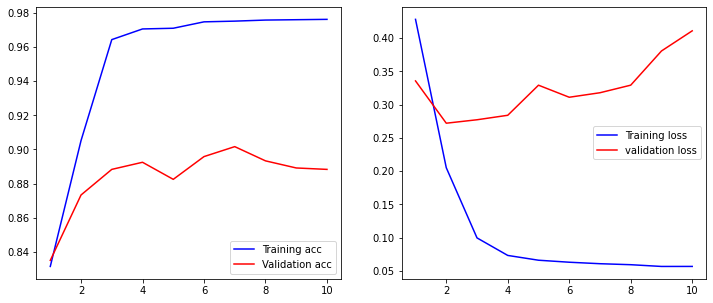

In [ ]:
plot_model(history)

> save models in variations for deployment

In [ ]:
model.save('model.h5')

In [ ]:
model3.save('CNNModel.h5')

>>> Note: Model deployment in progress ...